In [1]:
from bokeh.plotting import figure, output_notebook, show, gridplot
from bokeh.models.tickers import FixedTicker
from bokeh.models import NumeralTickFormatter, Range1d, LinearAxis, ColumnDataSource, HoverTool

import sys
import os
import pyfasta
import pandas as pd
import numpy as np
import allel
import functools

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# output live to notebook
output_notebook()

Loading BokehJS ...

In [4]:
import pandas as pd

In [5]:
%run setup.ipynb

0|name,1|chrom,2|start,3|stop,4|rr
CHX,X,20009764,24393108,5e-07
CH2R,2R,58984778,61545105,5e-07
CH2L,2L,1,2840000,5e-07
PEU2L,2L,2840001,5042389,2e-06
IH2L,2L,5078962,5788875,5e-07
IH3R,3R,38988757,41860198,5e-07
CH3R,3R,52161877,53200684,5e-07
CH3L,3L,1,1815119,5e-07
PEU3L,3L,1896830,4235209,2e-06
IH3L,3L,4264713,5031692,5e-07


In [6]:
genome

In [7]:
df_signals = pd.read_csv('../docs/signals.csv')
peak_start = df_signals.peak_start.copy()
peak_start[(df_signals.epicenter_arm == '2L') & (df_signals.peak_start_arm == '2R')] = 0
peak_stop = df_signals.peak_stop.copy()
peak_stop[(df_signals.epicenter_arm == '2R') & (df_signals.peak_stop_arm == '2L')] = len(genome['2R'])
df_signals['peak_start'] = peak_start
df_signals['peak_stop'] = peak_stop


In [8]:
df_signals.head()

,population,statistic,chromosome,rank,epicenter_arm,epicenter_start,epicenter_stop,focus_start_arm,focus_stop_arm,focus_start,focus_stop,peak_start_arm,peak_stop_arm,peak_start,peak_stop,minor_delta_aic,sum_delta_aic,overlapping_genes
0,BFM,H12,2,1,2L,2760001,2800000,2L,2L,2500001,2900000,2R,2L,0,3820000,784.588942,1736.143314,AGAP004712 AGAP004713 AGAP004714 AGAP004715 AG...
1,BFS,H12,2,1,2L,2420001,2460000,2L,2L,2420001,2720000,2R,2L,0,5040000,837.564914,1728.077230,AGAP004707 AGAP004708 AGAP004709 AGAP004710 AG...
2,UGS,H12,2,1,2R,28420001,28460000,2R,2R,28420001,28520000,2R,2R,26700001,29640000,731.211663,1602.087708,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...
3,GNS,H12,2,1,2L,2420001,2460000,2L,2L,1720001,2700000,2R,2L,0,5040000,754.285907,1554.083599,AGAP028435 AGAP004695 AGAP004696 AGAP004698 AG...
4,CMS,H12,3,1,3R,28580001,28620000,3R,3R,28540001,28640000,3R,3R,27160001,29460000,557.088350,1425.749559,AGAP009185 AGAP009187 AGAP009188 AGAP009189 AG...


In [9]:
df = df_signals[df_signals.epicenter_arm == '2R'].copy()
df.sort_values(by='peak_start', inplace=True)
df.head()

,population,statistic,chromosome,rank,epicenter_arm,epicenter_start,epicenter_stop,focus_start_arm,focus_stop_arm,focus_start,focus_stop,peak_start_arm,peak_stop_arm,peak_start,peak_stop,minor_delta_aic,sum_delta_aic,overlapping_genes
26,AOM,H12,2,2,2R,8320001,8360000,2R,2R,8320001,8380000,2R,2R,7320001,9660000,201.325736,484.528360,AGAP001683 AGAP001684
79,AOM,H12,2,8,2R,13780001,13820000,2R,2R,13580001,13820000,2R,2R,12500001,14140000,40.193479,95.192387,AGAP002007
50,BFM,H12,2,6,2R,24820001,24860000,2R,2R,24820001,24860000,2R,2R,24280001,25220000,109.785011,247.732873,AGAP002636 AGAP002637 AGAP013045 AGAP002638 AG...
2,UGS,H12,2,1,2R,28420001,28460000,2R,2R,28420001,28520000,2R,2R,26700001,29640000,731.211663,1602.087708,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...
7,CMS,H12,2,1,2R,28400001,28440000,2R,2R,28400001,28460000,2R,2R,26820001,30760000,602.973137,1231.638447,AGAP002859


In [10]:
def stack_overlaps(df, start_col, stop_col, max_levels=20):
    occupants = [None] * max_levels
    out = []
    for _, cur in df.iterrows():
        
        level = 0
        prv = occupants[level]
        # search upwards to find the first vacant level
        while prv is not None and cur[start_col] <= (prv[stop_col] + 1000000):
            level += 1
            prv = occupants[level]
        occupants[level] = cur
        out.append(level)
    return np.asarray(out)                


In [11]:
levels = stack_overlaps(df, 'peak_start', 'peak_stop')
df['levels'] = levels
levels

array([0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2])

In [12]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

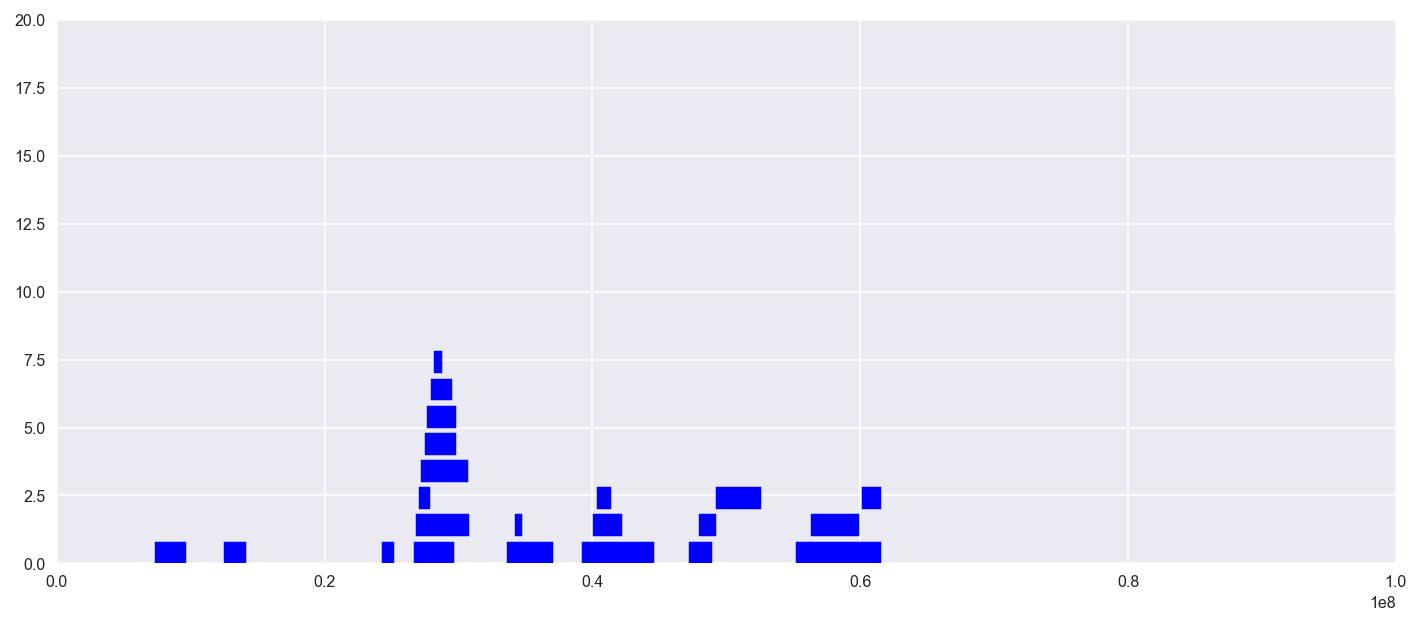

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
patches = list()
for start, stop, level in zip(df.peak_start.values, df.peak_stop.values, levels):
    if not np.isnan(start):
        ax.add_patch(Rectangle(xy=(start, level), width=(stop - start + 1), height=.8, color='b'))
ax.set_xlim(0, 1e8)
ax.set_ylim(0, 20);

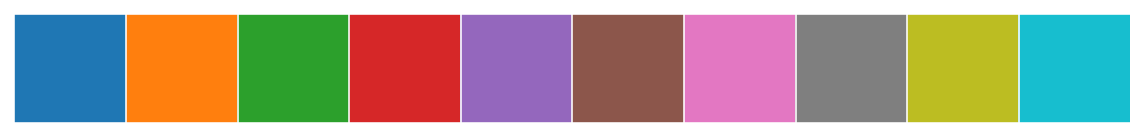

In [21]:
import seaborn as sns
palette = sns.color_palette()
sns.palplot(palette)

In [23]:
mpl.colors.rgb2hex(palette[0])

'#1f77b4'

In [34]:
import bokeh.models

In [74]:
source = ColumnDataSource(data={
    'population': df.population,
    'statistic': df.statistic,
    'chromosome': df.chromosome,
    'rank': df['rank'],
    'score': df.sum_delta_aic.astype(int),
    'peak_start': df.peak_start/1e6,
    'peak_stop': df.peak_stop/1e6,
    'focus_start': df.focus_start/1e6,
    'focus_stop': df.focus_stop/1e6,    
    'bottom': df.levels,
    'top': df.levels + .8,
})

hover = HoverTool(tooltips=[
    ("Population", '@population'),
    ("Statistic", '@statistic'),
    ("Score", '@score'),
    ("Focus", "@focus_start-@focus_stop Mbp"),
])

# hover = HoverTool(tooltips="""
#     <div><a href="/signal/@statistic/@population/chr@chromosome">@population | @statistic | @focus_start-@focus_stop</a></div>
# """)

fig = figure(plot_width=800, plot_height=200, 
             tools="tap,xpan,xzoom_in,xzoom_out,xwheel_zoom,reset".split() + [hover],
             toolbar_location='above', active_drag='xpan', active_scroll='xwheel_zoom')
fig.quad(bottom='bottom', top='top', left='peak_start', right='focus_start', source=source, color=mpl.colors.rgb2hex(palette[0]), alpha=.5, line_width=0)
fig.quad(bottom='bottom', top='top', left='focus_start', right='focus_stop', source=source, color=mpl.colors.rgb2hex(palette[3]), alpha=.7, line_width=0)
fig.quad(bottom='bottom', top='top', left='focus_stop', right='peak_stop', source=source, color=mpl.colors.rgb2hex(palette[0]), alpha=.5, line_width=0)
fig.x_range = Range1d(0, len(genome['2R'])/1e6)
fig.yaxis.visible = False
fig.ygrid.visible = False
fig.xaxis.axis_label = "Chromosome 2R position (Mbp)"
url = '/signal/@statistic/@population/chr@chromosome/@rank/'
taptool = fig.select(type=bokeh.models.TapTool, )
taptool.callback = bokeh.models.OpenURL(url=url)
show(fig)

In [19]:
fig.ygrid.visible

[Grid(id='97fa7e4c-4897-4d97-97df-10f4d4b3164e', ...)]

In [12]:
p = figure()
source = ColumnDataSource(df)
hover = HoverTool(
    tooltips=[
        ('Y-value', "$y"),
        ("label", "@label")],
    mode="mouse"
)

p.add_tools(hover)
p.circle('x', 'y', source=source, size=30)
show(p)

In [5]:
p = figure()
p.line(x=[1, 2, 3], y=[4,6,2])
show(p)